In [1]:
import os
import numpy as np
import cv2
import random
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt
from torchmetrics import F1Score, Precision, Recall
import wandb

/media/HDD/fdittaro/env/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
wandb.login()

wandb: Currently logged in as: federico-dittaro (federico-dittaro-university-of-udine) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
wandb.init(
    project="Second_phase_WE3DS_dataset-segmentation",
    group="EfficientNetB0_UNet++", 
    tags=["batch_64"],
    name=f"run_WE3DS_seg_ENB0+UNet++_bs64",
    config={
        "epochs": 50,
        "batch_size": 64
    }
)

In [4]:
# Unisce tutti gli ID in un unico elenco esuddivide il dataset in 70/15/15 (training , validation, test)
random.seed(42)
with open("../../../WE3DS-dataset/train.txt") as f:
    train_ids = [line.strip() for line in f]
with open("../../../WE3DS-dataset/test.txt") as f:
    test_ids = [line.strip() for line in f]

all_ids = train_ids + test_ids
total = len(all_ids)

random.shuffle(all_ids)
train_size = int(total * 0.70)
val_size = int(total * 0.15)
test_size = total - train_size - val_size

train_ids = all_ids[:train_size]
val_ids = all_ids[train_size:train_size + val_size]
test_ids = all_ids[train_size + val_size:]

print(f"Training set: {len(train_ids)} immagini")
print(f"Validation set: {len(val_ids)} immagini")
print(f"Test set: {len(test_ids)} immagini")

Training set: 1797 immagini
Validation set: 385 immagini
Test set: 386 immagini


In [5]:
class WE3DSDataset(Dataset):
    """
    image_ids: lista degli ID immagine
    images_dir: cartella dove si trovano le immagini
    masks_dir: cartella dove si trovano le maschere corrispondenti
    transform: trasformazioni da applicare
    """
    def __init__(self, image_ids, images_dir, masks_dir, transform=None):
        self.image_ids = image_ids
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

    """ Restituisce la lunghezza del dataset (necessario per PyTorch DataLoader)."""
    def __len__(self):
        return len(self.image_ids)

    """ 
    Dato un indice recupera la coppia (immagine, maschera), applica trasformazioni coerenti ad entrambi
    e le converte in tensori Pytorch.
    """
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.images_dir, f"img_{img_id}.png")
        mask_path = os.path.join(self.masks_dir, f"img_{img_id}.png")

        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = torch.tensor(np.array(augmented['image']) / 255.0, dtype=torch.float32).permute(2, 0, 1)
            mask = torch.tensor(np.array(augmented['mask']), dtype=torch.long)

        return image, mask

""" Ridimensiona immagini e maschere a (256,256) """
train_transform = A.Compose([A.Resize(256, 256)])
val_transform = A.Compose([A.Resize(256, 256)])
test_transform = A.Compose([A.Resize(256, 256)])

images_dir = "../../../WE3DS-dataset/images"
masks_dir = "../../../WE3DS-dataset/annotations/segmentation/SegmentationLabel"

train_loader = DataLoader(WE3DSDataset(train_ids, images_dir, masks_dir, transform=train_transform), batch_size=64, shuffle=True)
val_loader = DataLoader(WE3DSDataset(val_ids, images_dir, masks_dir, transform=val_transform), batch_size=64, shuffle=False)
test_loader = DataLoader(WE3DSDataset(test_ids, images_dir, masks_dir, transform=test_transform), batch_size=64, shuffle=False)


In [6]:
"""Costruzione del modello UNet con EfficientNetB0 come backbone. Il modello carica pesi pre-addestrati su ImageNet
per l'encoder. Le immagini in input hanno tre canali (RGB) e 19 classi di output (una per ciascuna classe di
segmentazione)"""
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=19
)

num_params = count_parameters(model)
print(f" Numero di parametri allenabili: {num_params:,}")

 Numero di parametri allenabili: 6,572,191


In [7]:
"""Imposta il dispositivo di calcolo sulla GPU e sposta il modello sul dispositivo. 
Utilizza la Cross Entropy Loss come funzione di perdita e Adam come ottimizzatore con leraning rate 0.001"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
"""Calcolo dell'IoU:
- intersection: numero di pixel correttamente classificati per quella classe
- union: tutti i pixel predetti o etichettati come quella classe
Restituisce la media delle IoU tra tutte le classi, ignorando i nan (classe non presente nè nella predizione
nè nella label)"""
def compute_iou(preds, labels, num_classes):
    preds = torch.argmax(preds, dim=1).view(-1)
    labels = labels.view(-1)
    ious = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return torch.tensor(ious).nanmean().item()

In [9]:
"""Addestramento del modello per una singola epoca"""
def train_one_epoch(model, dataloader, loss_fn, optimizer):
    model.train()
    running_loss = 0
    for images, masks in tqdm(dataloader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

"""Valuta il modello su un dataloader di validazione (senza l'aggiornamento dei pesi)"""
def validate(model, dataloader, loss_fn):
    f1_metric = F1Score(num_classes=19, average='macro', task='multiclass').to(device)
    precision_metric = Precision(num_classes=19, average='macro', task='multiclass').to(device)
    recall_metric = Recall(num_classes=19, average='macro', task='multiclass').to(device)
    model.eval()
    val_loss = 0
    iou_total = 0
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            f1_metric.update(preds, masks)
            precision_metric.update(preds, masks)
            recall_metric.update(preds, masks)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()
            iou_total += compute_iou(outputs, masks, num_classes=19)
    val_f1 = f1_metric.compute().item()
    val_precision = precision_metric.compute().item()
    val_recall = recall_metric.compute().item()
    return val_loss / len(dataloader), iou_total / len(dataloader), val_f1, val_precision, val_recall


In [10]:
"""Addestra il modello per 50 epoche salvando il modello migliore. L'addestramento si interrompe se per 10 epoche
non avviene nessun miglioramento."""
num_epochs = 50
best_val_loss = float('inf')
patience = 10
counter = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer)
    val_loss, val_iou, val_f1, val_precision, val_recall = validate(model, val_loader, loss_fn)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | F1: {val_f1:.4f} | Precision: {val_precision:.4f} | Recall: {val_recall:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "ENB0+UNet++_models/ENB0UNet++_WE3DS_segmentation_bs64.pth")
        print("✅ Model saved.")
        counter = 0
    else:
        counter += 1
        print(f"No improvement. EarlyStopping counter: {counter}/{patience}")
        if counter >= patience:
            print("⏹️ Early stopping triggered.")
            break

    wandb.log({
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_iou": val_iou,
        "val_f1": val_f1,
        "val_precision": val_precision,
        "val_recall": val_recall
    })

wandb.finish()


Epoch 1/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.2334 | Val Loss: 0.1965 | IoU: 0.1232 | F1: 0.0582 | Precision: 0.0575 | Recall: 0.0588
✅ Model saved.

Epoch 3/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.1010 | Val Loss: 0.1760 | IoU: 0.1232 | F1: 0.0582 | Precision: 0.0575 | Recall: 0.0588
✅ Model saved.

Epoch 4/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0827 | Val Loss: 0.1804 | IoU: 0.1232 | F1: 0.0582 | Precision: 0.0575 | Recall: 0.0588
No improvement. EarlyStopping counter: 1/10

Epoch 5/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.77s/it]


Train Loss: 0.0724 | Val Loss: 0.1851 | IoU: 0.1232 | F1: 0.0582 | Precision: 0.0575 | Recall: 0.0588
No improvement. EarlyStopping counter: 2/10

Epoch 6/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.77s/it]


Train Loss: 0.0661 | Val Loss: 0.1871 | IoU: 0.1232 | F1: 0.0582 | Precision: 0.0575 | Recall: 0.0588
No improvement. EarlyStopping counter: 3/10

Epoch 7/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0625 | Val Loss: 0.1886 | IoU: 0.1233 | F1: 0.0584 | Precision: 0.1106 | Recall: 0.0590
No improvement. EarlyStopping counter: 4/10

Epoch 8/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0639 | Val Loss: 0.1778 | IoU: 0.1265 | F1: 0.0642 | Precision: 0.1133 | Recall: 0.0620
No improvement. EarlyStopping counter: 5/10

Epoch 9/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.78s/it]


Train Loss: 0.0595 | Val Loss: 0.1932 | IoU: 0.1233 | F1: 0.0584 | Precision: 0.1163 | Recall: 0.0589
No improvement. EarlyStopping counter: 6/10

Epoch 10/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.77s/it]


Train Loss: 0.0541 | Val Loss: 0.1796 | IoU: 0.1232 | F1: 0.0582 | Precision: 0.1751 | Recall: 0.0588
No improvement. EarlyStopping counter: 7/10

Epoch 11/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.77s/it]


Train Loss: 0.0521 | Val Loss: 0.1510 | IoU: 0.1480 | F1: 0.0978 | Precision: 0.1763 | Recall: 0.0898
✅ Model saved.

Epoch 12/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0466 | Val Loss: 0.1484 | IoU: 0.1367 | F1: 0.0871 | Precision: 0.2036 | Recall: 0.0757
✅ Model saved.

Epoch 13/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.77s/it]


Train Loss: 0.0458 | Val Loss: 0.1327 | IoU: 0.1509 | F1: 0.1028 | Precision: 0.1868 | Recall: 0.0910
✅ Model saved.

Epoch 14/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0482 | Val Loss: 0.1123 | IoU: 0.1437 | F1: 0.1294 | Precision: 0.2632 | Recall: 0.1137
✅ Model saved.

Epoch 15/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0427 | Val Loss: 0.1067 | IoU: 0.1145 | F1: 0.1220 | Precision: 0.2222 | Recall: 0.1002
✅ Model saved.

Epoch 16/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0403 | Val Loss: 0.1170 | IoU: 0.1171 | F1: 0.0962 | Precision: 0.2404 | Recall: 0.0810
No improvement. EarlyStopping counter: 1/10

Epoch 17/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.77s/it]


Train Loss: 0.0368 | Val Loss: 0.0974 | IoU: 0.1666 | F1: 0.1668 | Precision: 0.3316 | Recall: 0.1402
✅ Model saved.

Epoch 18/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0352 | Val Loss: 0.0687 | IoU: 0.2312 | F1: 0.2809 | Precision: 0.3792 | Recall: 0.2474
✅ Model saved.

Epoch 19/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0328 | Val Loss: 0.0522 | IoU: 0.2642 | F1: 0.3070 | Precision: 0.3962 | Recall: 0.2819
✅ Model saved.

Epoch 20/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0316 | Val Loss: 0.0625 | IoU: 0.2752 | F1: 0.3314 | Precision: 0.3950 | Recall: 0.3188
No improvement. EarlyStopping counter: 1/10

Epoch 21/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.77s/it]


Train Loss: 0.0302 | Val Loss: 0.0419 | IoU: 0.3123 | F1: 0.3753 | Precision: 0.4415 | Recall: 0.3484
✅ Model saved.

Epoch 22/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0319 | Val Loss: 0.0518 | IoU: 0.2796 | F1: 0.3553 | Precision: 0.4386 | Recall: 0.3448
No improvement. EarlyStopping counter: 1/10

Epoch 23/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.77s/it]


Train Loss: 0.0291 | Val Loss: 0.0387 | IoU: 0.3111 | F1: 0.3911 | Precision: 0.4281 | Recall: 0.3821
✅ Model saved.

Epoch 24/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0359 | Val Loss: 0.0382 | IoU: 0.2995 | F1: 0.3834 | Precision: 0.4328 | Recall: 0.3849
✅ Model saved.

Epoch 25/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.77s/it]


Train Loss: 0.0395 | Val Loss: 0.1176 | IoU: 0.2353 | F1: 0.2748 | Precision: 0.3641 | Recall: 0.2581
No improvement. EarlyStopping counter: 1/10

Epoch 26/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.77s/it]


Train Loss: 0.0307 | Val Loss: 0.0657 | IoU: 0.2991 | F1: 0.3601 | Precision: 0.4845 | Recall: 0.3452
No improvement. EarlyStopping counter: 2/10

Epoch 27/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.77s/it]


Train Loss: 0.0276 | Val Loss: 0.0276 | IoU: 0.4677 | F1: 0.4448 | Precision: 0.4667 | Recall: 0.4528
✅ Model saved.

Epoch 28/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0262 | Val Loss: 0.0348 | IoU: 0.3748 | F1: 0.4478 | Precision: 0.4896 | Recall: 0.4366
No improvement. EarlyStopping counter: 1/10

Epoch 29/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.77s/it]


Train Loss: 0.0250 | Val Loss: 0.0308 | IoU: 0.3902 | F1: 0.4550 | Precision: 0.4993 | Recall: 0.4780
No improvement. EarlyStopping counter: 2/10

Epoch 30/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.77s/it]


Train Loss: 0.0259 | Val Loss: 0.0315 | IoU: 0.3871 | F1: 0.4128 | Precision: 0.4532 | Recall: 0.4053
No improvement. EarlyStopping counter: 3/10

Epoch 31/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.77s/it]


Train Loss: 0.0254 | Val Loss: 0.0248 | IoU: 0.4986 | F1: 0.4791 | Precision: 0.4945 | Recall: 0.4830
✅ Model saved.

Epoch 32/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0249 | Val Loss: 0.0266 | IoU: 0.4274 | F1: 0.4606 | Precision: 0.4906 | Recall: 0.4574
No improvement. EarlyStopping counter: 1/10

Epoch 33/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0231 | Val Loss: 0.0322 | IoU: 0.4270 | F1: 0.5041 | Precision: 0.6013 | Recall: 0.4956
No improvement. EarlyStopping counter: 2/10

Epoch 34/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.77s/it]


Train Loss: 0.0202 | Val Loss: 0.0438 | IoU: 0.4099 | F1: 0.4967 | Precision: 0.6080 | Recall: 0.4680
No improvement. EarlyStopping counter: 3/10

Epoch 35/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0198 | Val Loss: 0.0299 | IoU: 0.4460 | F1: 0.5083 | Precision: 0.5918 | Recall: 0.4834
No improvement. EarlyStopping counter: 4/10

Epoch 36/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0216 | Val Loss: 0.0242 | IoU: 0.5210 | F1: 0.5036 | Precision: 0.5539 | Recall: 0.5079
✅ Model saved.

Epoch 37/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0214 | Val Loss: 0.0229 | IoU: 0.5264 | F1: 0.5124 | Precision: 0.5372 | Recall: 0.5053
✅ Model saved.

Epoch 38/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0218 | Val Loss: 0.0272 | IoU: 0.4609 | F1: 0.4872 | Precision: 0.5280 | Recall: 0.4843
No improvement. EarlyStopping counter: 1/10

Epoch 39/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0190 | Val Loss: 0.0223 | IoU: 0.5312 | F1: 0.5205 | Precision: 0.5797 | Recall: 0.5169
✅ Model saved.

Epoch 40/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0175 | Val Loss: 0.0210 | IoU: 0.5412 | F1: 0.5248 | Precision: 0.5554 | Recall: 0.5349
✅ Model saved.

Epoch 41/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0196 | Val Loss: 0.0265 | IoU: 0.4956 | F1: 0.5031 | Precision: 0.5983 | Recall: 0.4719
No improvement. EarlyStopping counter: 1/10

Epoch 42/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.77s/it]


Train Loss: 0.0227 | Val Loss: 0.0260 | IoU: 0.4407 | F1: 0.4963 | Precision: 0.5537 | Recall: 0.4996
No improvement. EarlyStopping counter: 2/10

Epoch 43/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.77s/it]


Train Loss: 0.0287 | Val Loss: 0.0358 | IoU: 0.3479 | F1: 0.4678 | Precision: 0.5262 | Recall: 0.4529
No improvement. EarlyStopping counter: 3/10

Epoch 44/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0350 | Val Loss: 0.0446 | IoU: 0.2969 | F1: 0.3904 | Precision: 0.4281 | Recall: 0.3911
No improvement. EarlyStopping counter: 4/10

Epoch 45/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0248 | Val Loss: 0.0243 | IoU: 0.5095 | F1: 0.5015 | Precision: 0.5149 | Recall: 0.4909
No improvement. EarlyStopping counter: 5/10

Epoch 46/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.77s/it]


Train Loss: 0.0210 | Val Loss: 0.0253 | IoU: 0.4830 | F1: 0.4888 | Precision: 0.5850 | Recall: 0.4604
No improvement. EarlyStopping counter: 6/10

Epoch 47/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0203 | Val Loss: 0.0233 | IoU: 0.5176 | F1: 0.5215 | Precision: 0.5879 | Recall: 0.4843
No improvement. EarlyStopping counter: 7/10

Epoch 48/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.77s/it]


Train Loss: 0.0192 | Val Loss: 0.0187 | IoU: 0.5579 | F1: 0.5465 | Precision: 0.6371 | Recall: 0.5455
✅ Model saved.

Epoch 49/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


Train Loss: 0.0201 | Val Loss: 0.0211 | IoU: 0.5455 | F1: 0.5366 | Precision: 0.5649 | Recall: 0.5271
No improvement. EarlyStopping counter: 1/10

Epoch 50/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.77s/it]

Train Loss: 0.0247 | Val Loss: 0.0273 | IoU: 0.4662 | F1: 0.4469 | Precision: 0.5040 | Recall: 0.4484
No improvement. EarlyStopping counter: 2/10


train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▁▁▁▁▁▁▁▁▂▂▂▂▃▄▅▆▅▆▆▅▇▇▇▆▇▇▇▇▇▇██▇▇▆▇██▇
val_iou,▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂▃▄▄▄▄▃▄▅▅▅▆▆▆▆▇▆██▇▆▇▇▇█▇
val_loss,█▃▃▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▁▁▁▁▂▂▂▂▃▃▄▃▃▄▅▅▆▆▆▅▆▆▆▇▇▇███▇▇█▇█▇▆██▇
val_recall,▁▁▁▁▁▁▁▁▁▁▁▂▁▂▄▅▅▅▆▆▅▇▆▇▆▇▇▇▇▇▇██▇▇▇▇▇█▇
train_loss,0.0247
val_f1,0.44691
val_iou,0.46623
val_loss,0.02731
val_precision,0.50401


In [11]:
"""Carica i nomi delle classi e i rispettivi colori RGB"""
def load_class_info(colors_path, names_path):
    with open(colors_path, 'r') as f:
        class_colors = [list(map(int, line.strip().split(','))) for line in f]
    with open(names_path, 'r') as f:
        class_names = [line.strip() for line in f]
    return np.array(class_colors), class_names

class_colors, class_names = load_class_info(
    "../../../WE3DS-dataset/class_colors.txt",
    "../../../WE3DS-dataset/class_names.txt"
)

In [12]:
"""Carica il modello addestrato e lo imposta in modalità di valutazione"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("ENB0+UNet++_models/ENB0UNet++_WE3DS_segmentation_bs64.pth", map_location=device))
model.to(device)
model.eval()

val_transform = A.Compose([A.Resize(256, 256)])

test_dataset = WE3DSDataset(
    image_ids=test_ids,
    images_dir="../../../WE3DS-dataset/images",
    masks_dir="../../../WE3DS-dataset/annotations/segmentation/SegmentationLabel",
    transform=val_transform
)

/tmp/ipykernel_27769/1157018947.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ENB0+UNet++_models/ENB0UNet++_WE3DS_segmentation_bs64.p

In [13]:
"""Trasforma una maschera di segmentazione in un'immagine colorata RGB
creando un'immagine vuota per poi colorare i pixel della maschera con il colore corrispondente"""
def decode_segmap(mask, class_colors):
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in enumerate(class_colors):
        color_mask[mask == class_idx] = color
    return color_mask

In [14]:
def print_test_images(test_ids):
    print("Immagini nel test set:")
    for img_id in test_ids:
        print(f"img_{img_id}.png")

print_test_images(test_ids)

Immagini nel test set:
img_02415.png
img_02330.png
img_01036.png
img_01064.png
img_01819.png
img_00483.png
img_02166.png
img_01111.png
img_01304.png
img_01530.png
img_00842.png
img_01307.png
img_00281.png
img_01207.png
img_02183.png
img_00160.png
img_02145.png
img_01268.png
img_01834.png
img_00087.png
img_00935.png
img_01771.png
img_01003.png
img_01517.png
img_02098.png
img_01106.png
img_01239.png
img_02320.png
img_00871.png
img_01882.png
img_01755.png
img_00253.png
img_00683.png
img_02115.png
img_01026.png
img_02102.png
img_01282.png
img_02442.png
img_02333.png
img_01599.png
img_00387.png
img_00463.png
img_00431.png
img_00880.png
img_00157.png
img_00393.png
img_02311.png
img_00317.png
img_00038.png
img_00037.png
img_00121.png
img_02028.png
img_02173.png
img_01356.png
img_02338.png
img_01899.png
img_01505.png
img_00605.png
img_02061.png
img_00123.png
img_00911.png
img_00101.png
img_00044.png
img_01782.png
img_02535.png
img_00876.png
img_02294.png
img_01462.png
img_02516.png
img_02095.p

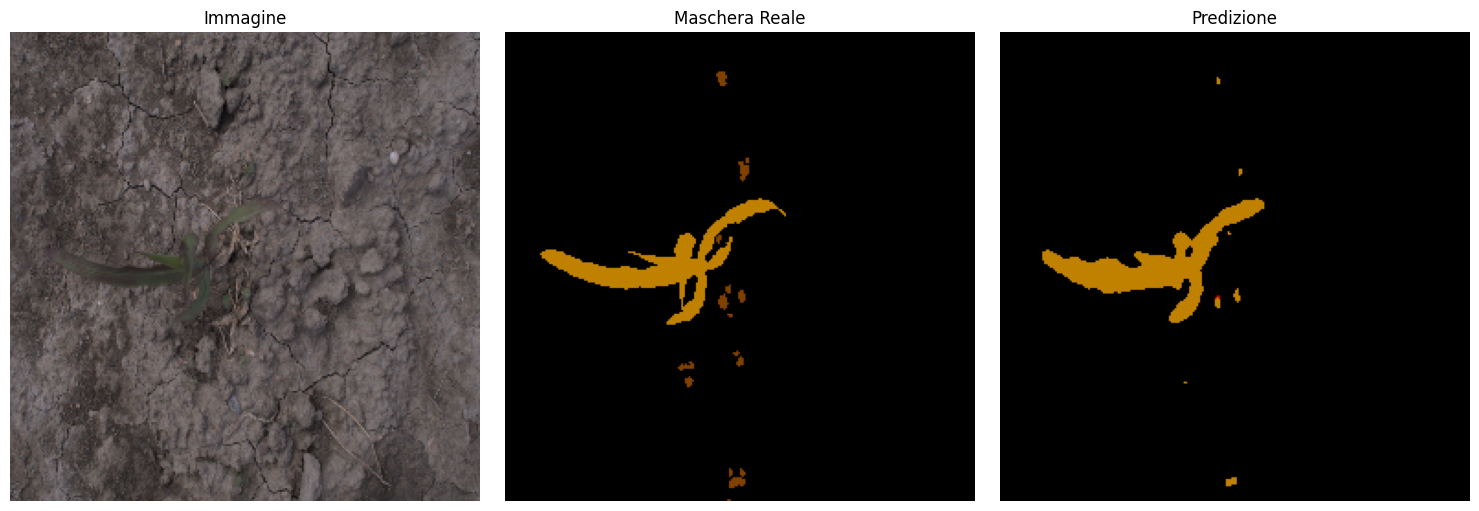

In [15]:
def visualize_prediction(filename, model, dataset):
    img_id = filename.replace("img_", "").replace(".png", "")
    idx = dataset.image_ids.index(img_id)
    image, mask = dataset[idx]
    input_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()

    mask_rgb = decode_segmap(mask_np, class_colors)
    pred_rgb = decode_segmap(pred, class_colors)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Immagine")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask_rgb)
    plt.title("Maschera Reale")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_rgb)
    plt.title("Predizione")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
visualize_prediction("img_00740.png", model, test_dataset)

# img_00858.png    img_00740.png     img_01178.png    img_01503.png